In [1]:
# from google.colab import drive
# import os

# drive.mount('/content/drive/')

# path = './drive/MyDrive/NLP-Twitter-Sentiment-Analysis/'

path = './'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

from rnnlibrary import rnn_model

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from itertools import product

In [3]:
training_data = pd.read_csv(path + 'Datas/twitter_training.csv')
validation_data = pd.read_csv(path +'Datas/twitter_validation.csv')

training_data.columns = ['id', 'entity', 'sentiment', 'context']
validation_data.columns = ['id', 'entity', 'sentiment', 'context']

df = pd.concat(
    [training_data, validation_data],
    ignore_index=True,
)

df = df.drop(['id', 'entity'], axis=1)

df.tail()

,sentiment,context
75675,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
75676,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75677,Positive,Today sucked so it’s time to drink wine n play...
75678,Positive,Bought a fraction of Microsoft today. Small wins.
75679,Neutral,Johnson & Johnson to stop selling talc baby po...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75680 entries, 0 to 75679
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  75680 non-null  object
 1   context    74994 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [5]:
df.dropna(inplace=True)

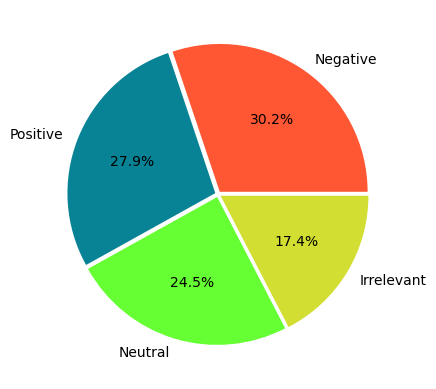

In [6]:
colors = [
    '#FF5733', '#088395', '#66FF33', '#D2DE32'
]

def plot_sentiment(data):
    explodes = ([0.02 for _ in range(len(set(data['sentiment'])))])
    value_counts = data['sentiment'].value_counts()
    labels = value_counts.index
    values = value_counts.values

    plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', explode=explodes)
    plt.show()

plot_sentiment(df)

In [7]:
sentiment_values = df['sentiment'].value_counts().index

def update_sentiment_values(sentiment):

    if sentiment == sentiment_values[0]:
        return 0
    elif sentiment == sentiment_values[1]:
        return 1
    elif sentiment == sentiment_values[2]:
        return 2
    elif sentiment == sentiment_values[3]:
        return 3
    else:
        return -1

df['sentiment'] = df['sentiment'].apply(update_sentiment_values)

In [8]:
>>> import nltk
>>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\90530\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
eng_stopwords = stopwords.words('english')

sample_text = df['context'][75675]
sample_text = re.sub('[^a-zA-Z]', ' ', sample_text)
sample_text = [word.lower() for word in sample_text.split() if word.lower() not in eng_stopwords]

In [10]:
# original text
df['context'][75675]

'⭐️ Toronto is the arts and culture capital of Canada, it’s no wonder! If you want to start planning, be sure to check out our GTA Real Estate market report for Fall 2020, it has all the info you need to finally make a move! blog.remax.ca/toronto-housin… twitter.com/kevinyoufool/s…'

In [11]:
# after preprocessing
' '.join(sample_text)

'toronto arts culture capital canada wonder want start planning sure check gta real estate market report fall info need finally make move blog remax ca toronto housin twitter com kevinyoufool'

In [12]:
df.head()

,sentiment,context
0,1,I am coming to the borders and I will kill you...
1,1,im getting on borderlands and i will kill you ...
2,1,im coming on borderlands and i will murder you...
3,1,im getting on borderlands 2 and i will murder ...
4,1,im getting into borderlands and i can murder y...


In [13]:
eng_stopwords = stopwords.words('english')

def preprocessing_context(context):
    context = re.sub('[^a-zA-Z]', ' ' ,context)
    context = [word.lower() for word in context.split() if word.lower() not in eng_stopwords]
    return ' '.join(context)

df['context'] = df['context'].apply(preprocessing_context)

df.head()

,sentiment,context
0,1,coming borders kill
1,1,im getting borderlands kill
2,1,im coming borderlands murder
3,1,im getting borderlands murder
4,1,im getting borderlands murder


In [14]:
y = df['sentiment']
X = df['context']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
def word_tokenizer(n_words):

    tokenizer = Tokenizer(n_words)

    tokenizer.fit_on_texts(X)

    X_train_token = tokenizer.texts_to_sequences(X_train)
    X_test_token = tokenizer.texts_to_sequences(X_test)

    num_tokens = np.array([len(token) for token in X_train_token + X_test_token])

    max_token = int(num_tokens.mean()) + 2 * int(num_tokens.std())

    X_train_tokenized_pad = pad_sequences(X_train_token, maxlen=max_token)
    X_test_tokenized_pad = pad_sequences(X_test_token, maxlen=max_token)

    y_train_categorical = to_categorical(y_train)
    y_test_categorical = to_categorical(y_test)

    return X_train_tokenized_pad, X_test_tokenized_pad, y_train_categorical, y_test_categorical, num_tokens, max_token, tokenizer

In [16]:
num_words = len(set(' '.join([a for a in X]).split(' ')))

print(f"Total number of uniq words: {num_words}")

Total number of uniq words: 29645


In [17]:
(
    X_train_tokenized_pad, X_test_tokenized_pad, y_train_categorical, y_test_categorical, num_tokens, max_token, tokenizer
) = word_tokenizer(num_words)

In [18]:
print("max token", max_token)
print('std', num_tokens.std())
print('mean', num_tokens.mean())

max token 27
std 8.037868368226333
mean 11.26220764327813


In [19]:
print(f"X_train shape : {X_train_tokenized_pad.shape}")
print(f"X_test shape : {X_test_tokenized_pad.shape}")
print(f"y_train shape : {y_train_categorical.shape}")
print(f"y_test shape : {y_test_categorical.shape}")

X_train shape : (59995, 27)
X_test shape : (14999, 27)
y_train shape : (59995, 4)
y_test shape : (14999, 4)


In [20]:
glove_path = path + 'Glove/glove.6B.100d.txt'

glove_embedding_matrix = {}

with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embedding_matrix[word] = vector

embedding_matrix_dim = 100

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_matrix_dim))

for word, index in tokenizer.word_index.items():
    vector = glove_embedding_matrix.get(word)

    if vector is not None:
        embedding_matrix[index] = vector

In [21]:
trained_model = pd.DataFrame(
    columns=[
            'RNN model', 'hiddedn activation function', 'output activation function', 'optimizer', 
            'accuracy', 'model history', 'model', 'saved_model_path'
            ])

rnn_models = ['GRU', "LSTM"]
hidded_activation_functions = ['tanh', 'sigmoid', 'softmax']
output_activation_functions = ['sigmoid', 'softmax']
optimizers = ['adam', 'rmsprop']

In [22]:
for rnn, hidded_ac_fun, output_ac_fun, optimizer in product(rnn_models, hidded_activation_functions, output_activation_functions, optimizers):

    check_point_name = f'{rnn}_{hidded_ac_fun}_{output_ac_fun}_{optimizer}.h5'

    accuracy, history, model= rnn_model(
        rnn_layer = rnn,
        max_token = max_token,
        input_dim = len(tokenizer.word_index) + 1 ,
        embedding_matrix = embedding_matrix,
        units = (128, 64, 32, 16),
        epochs = 100,
        hidden_activation = hidded_ac_fun,
        output_activation = output_ac_fun,
        optimizer = optimizer,
        check_point_name = check_point_name,
        use_es = True,
        train_data = X_train_tokenized_pad,
        test_data = X_test_tokenized_pad,
        train_label = y_train_categorical,
        test_label = y_test_categorical,
        path_to_save_model = path
    )
    trained_model.loc[len(trained_model)] = [rnn, hidded_ac_fun, output_ac_fun, optimizer, accuracy, history, model, check_point_name]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 27, 100)           2964500   
                                                                 
 gru (GRU)                   (None, 27, 128)           88320     
                                                                 
 dropout (Dropout)           (None, 27, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 27, 64)            37248     
                                                                 
 dropout_1 (Dropout)         (None, 27, 64)            0         
                                                                 
 gru_2 (GRU)                 (None, 27, 32)            9408      
                                                                 
 dropout_2 (Dropout)         (None, 27, 32)            0

In [ ]:
df.head(24)

In [ ]:
def loss_plot(model_history, rnn, hidded_ac_fun, output_ac_fun, optimizer, accuracy):
    plt.title(f"{rnn}-{hidded_ac_fun}-{output_ac_fun}-{optimizer}-{accuracy}")
    plt.plot(model_history.history['loss'], label='training loss')
    plt.plot(model_history.history['val_loss'], label='validation loss')
    plt.legend(['loss', 'val_loss'], loc='upper right')
    plt.show()

In [ ]:
for model_history, rnn, hidded_ac_fun, output_ac_fun, optimizer, accuracy in zip(
    trained_model['history'], trained_model['RNN model'], trained_model['hiddedn activation function'], 
    trained_model['output activation function'], trained_model['optimizer'], trained_model['accuracy']):
    
    loss_plot(model_history, rnn, hidded_ac_fun, output_ac_fun, optimizer, accuracy)